In [1]:
import numpy as np
import control as ct
import control.optimal as opt
import matplotlib.pyplot as plt
from scipy.integrate import RK45 as runge_kutta
import scipy.optimize as sc_opt

Для описания задачи оптимального управления нам нужна система ввода/вывода, временной горизонт, функция стоимости и (необязательно) набор ограничений на состояние и/или вход либо вдоль траектории, либо в конечное время. Задачу оптимального управления можно решить с помощью функции `solve_ocp()`:

$\verb|res = obc.solve_ocp(sys, horizon, X0, cost, constraints)|$

* sys - ввод системы с помощью класса `InputOutputSystemа`
* horizon - список моментов времени
* x0 - начальное положение
* cost - функция стоимости 
* constraints - ограничения

Функция cost имеет сигнатуру вызова `cost(t, x, u)` и должна возвращать стоимость в заданное время. Параметр terminal_cost можно использовать для указания функции стоимости для конечной точки траектории.

Параметр ограничений constraints представляет собой список ограничений. Каждое ограничение - это кортеж одной из следующих форм:

* $\verb|(LinearConstraint, A, lb, ub) : lb <= A @ np.hstack([x, u]) <= ub|$
* $\verb|(NonlinearConstraint, f, lb, ub) : lb <= f(x, u) <= ub|$

Параметр terminal_constraint можно использовать для указания ограничения, которое выполняется только в конечной точке траектории.

Результаты:

* res.success : True , если оптимизация была успешно решена
* res.inputs : оптимальный ввод
* res.states : траектория состояния (если return_x был True )
* res.time : копия вектора временного горизонта

#### Mixed-Integer Nonlinear Optimal Control

$
\begin{array}{rll}
\text{continuous time}: & 
    \dot{x}(t) = f_c(x(t), b(t)) = x^3(t) - b(t) \ , & 
    t \in \mathbb{R}_{\geq 0} \\
\text{discrete time}: & 
    x^{+} = f_d(x, b, k) = \text{Runge-Kutta-4}\ (f_c) \ , & 
    k \in \mathbb{Z}_{\geq 0}
\end{array}
$

$
\textbf{x} = (x(0), x(1), \dots, x(N)) \\
\textbf{b} = (b(0), b(1), \dots, b(N-1)) \\
\textbf{b} \in \mathbb{Z}^{N} \cap \mathbb{B}, \; \text{where} \;
\mathbb{Z} = \{0, 1\}, \;
\mathbb{B} = 
\left\{ b \in [0, 1]^N \mid \begin{align} 
    & b(k) \geq b(k-1) - b(k-2) \\
    & b(k) \geq b(k-1) - b(k-2) 
\end{align} \right\}
$

$
\text{objetive function}:
F(\textbf{x}, \textbf{b}) = \frac{1}{2} \sum\limits^{N}_{k=0} (x(k) - x_{ref})^2
$

$
\textbf{MINLP}: 
\min\limits_{\textbf{x}, \textbf{b}}
F(\textbf{x}, \textbf{b}) \\
\text{such that} \\
x^{+} = f_d(x, b, k) \\
x(0) = x_0 \\
\textbf{b} \in \mathbb{Z}^{N} \cap \mathbb{B} \\
N = 30, \ x_0 = 0.8, \ x_{ref} = 0.7
$

In [2]:
def runge_kutta(f, t, x, u):
    h = 0.05
    k1 = f(t, x, u)
    k2 = f(t + 0.5 * h, x + 0.5 * k1 * h, u)
    k3 = f(t + 0.5 * h, x + 0.5 * k2 * h, u)
    k4 = f(t + h, x + k3 * h, u)
    return x + (h / 6.) * (k1 + 2 * k2 + 2 * k3 + k4)

In [4]:
# continuous time variant
def f(t, x, u):
    return x ** 3 - u

# corresponding discrete time variant 
def f_update(t, x, u, params):
    return runge_kutta(f, t, x, u)

# output
def f_output(t, x, u, params):
    return x

# define the system (ODE)
sys = ct.NonlinearIOSystem(f_update, f_output, 
                           states=1, inputs=1, outputs=1, 
                           dt=True)

# define the cost function (trajectory cost)
cost = lambda x, u: ((x - x_ref) ** 2).item()

# define the constraints
constraints = [opt.input_range_constraint(sys, [0.0], [1.0])]
# (sc_opt.NonlinearConstraint, lambda u: u , lb, ub)

In [5]:
x_0 = np.array([0.8])
x_ref = np.array([0.7])
N, h = 30, 0.05
T = N * 0.05
Q, R = np.array([1]), np.array([0])

In [7]:
# solve the system

horizon = np.arange(0, N + 1) * h
result = opt.solve_ocp(
    sys, horizon, x_0, cost, constraints, initial_guess=[0.5],
    terminal_cost=cost)

Summary statistics:
* Cost function calls: 898
* Constraint calls: 959
* System simulations: 1826
* Final cost: 0.01797006666194928


In [9]:
# simulate the system dynamics
resp = ct.input_output_response(
    sys, horizon, result.inputs, x_0,
    t_eval=np.linspace(0, T, N))
t, y, u = resp.time, resp.outputs, resp.inputs

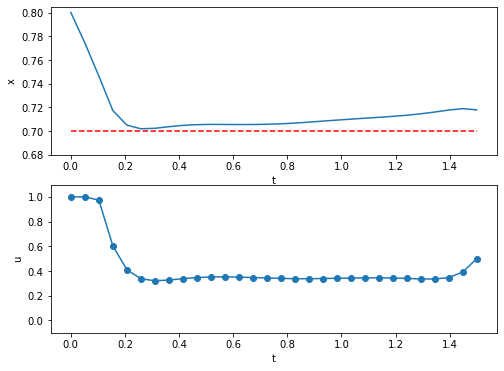

In [17]:
plt.figure(figsize=(8, 6))

plt.subplot(2, 1, 1)
plt.plot(t, y)
plt.hlines(x_ref, t[0], t[-1], linestyles='--', color='red')
plt.ylim(0.68, None)
plt.xlabel("t")
plt.ylabel("x")

plt.subplot(2, 1, 2)
plt.plot(t, u, '-o')
plt.ylim(-0.1, 1.1)
plt.xlabel("t")
plt.ylabel("u")

plt.show()